# LANL Earthquake Prediction &mdash; Finding L-estimators via PCA

*For visitors not aware, LANL Earthquake Prediction is a Kaggle Competition put out by
Los Alamos National Laboratory to predict the amount of time until an earthquake occurs.
The data is from an experiment set up in a lab to model the process of how earthquakes
occur on a global scale. The data consists of two time series: acoustic data (sampled at
approximately 4 MHz) and the time until the earthquake occurs. The goal is to predict the time
to failure for each sequence in the test data, each of which consists of 150k samples.*

Over the past couple weeks I've played around with this data set and read through some
public kernels. For the most part, these follow the same process: for each 150k sample chunk,
compute a bunch of manual statistics and try to build a robust estimator out of them (usually
some kind of gradient-boosted random forest). I had an interesting thought: is it possible to
automatically derive feature statistics from the data?

This notebook walks through the process of doing so. For those of you who just want to know
the bottom line, here it is: I performed PCA on the CDFs of pairwise distances within a sample
and used the top three it to build a simple $k$-NN regressor. It worked fairly well for how simple
it is, in my opinion. In more detail, the process is the following:

1. Filter high-frequency noise from the signal and decimate it to a more reasonable sample rate.
2. Estimate the CDF of the pairwise distances within the chunk.
3. Perform PCA on the CDF's for each chunk.
4. Create a $k$-NN regressor.

## Filtering Noise from the Signal

This problem actually begins as a signal processing problem. We are given a time-series of discretized
acoustic data, which immediately should lead to the question: "What are the frequencies we care about?"
The first step, then, is to plot the power spectrum over the signal:

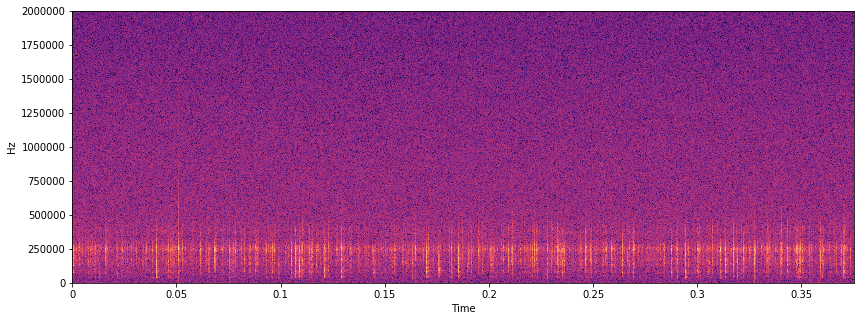

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display as lrd
np.warnings.filterwarnings('ignore')

def read(**kwargs):
    return pd.read_csv('../input/train.csv', **kwargs)

def spectrum(x, sr):
    Xr, Xi = lr.stft(np.real(x).astype(float)), lr.stft(np.imag(x).astype(float))
    Xdb = lr.amplitude_to_db(np.sqrt(abs(Xr)**2 + abs(Xi)**2))
    plt.figure(figsize=(14, 5))
    lrd.specshow(Xdb, sr=int(sr), x_axis='time', y_axis='hz')
    plt.show()
    
def waveplot(x, sr):
    xr, xi = np.real(x).copy(), np.imag(x).copy()
    plt.figure(figsize=(14, 5))
    lrd.waveplot(xr.astype(float), sr=int(sr))
    lrd.waveplot(xi.astype(float), sr=int(sr))
    plt.show()
    
x = read(nrows=1500000).acoustic_data.values
spectrum(x, 4e6)

Right off the bat, we can see that most of the signal is noise above ~300 kHz. This can be
from a number of sources&mdash;thermal noise, quantization error, room noise, and so on&mdash;but
the point is that this noise only serves to make predictions more difficult. We would like to isolate
the band which has the highest signal-to-noise ratio.

The other interesting thing here is that it looks like the signal is a series of pulses. I don't have
a good understanding of earthquakes, but I would guess that these are from micro-slips that occur leading
up to the earthquake. Of course, an earthquake is just another slip as well, so I am curious whether it
is possible to model the whole process as a series of slips of different magnitudes.

Anyway, let's filter out the noise. I isolated a small band from 240 kHz to 260 kHz using a linear-phase
FIR filter, de-modulated the signal to baseband, and decimated it by a factor of 90 (~45 kHz).

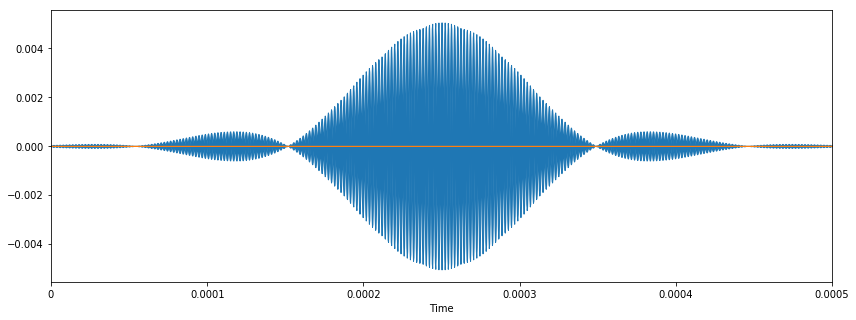

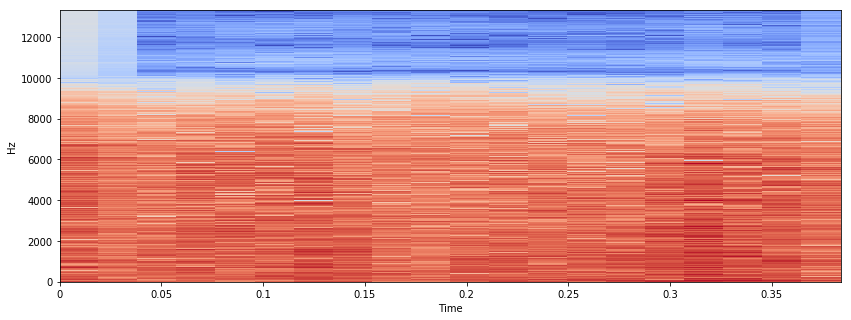

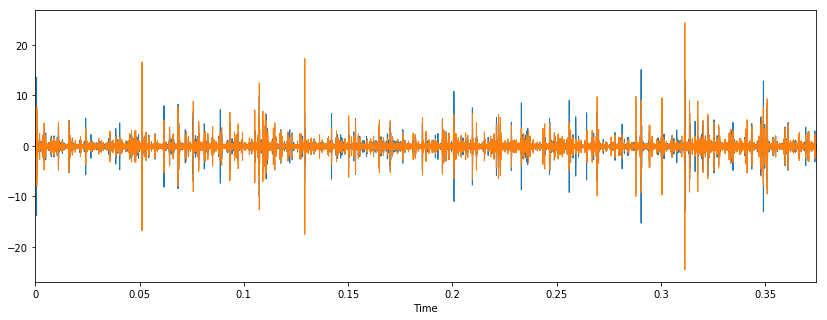

In [2]:
from scipy.signal import firls, convolve, decimate
from scipy.spatial.distance import pdist

filt = firls(2001, bands=[0,240e3,245e3,250e3,255e3,2e6], desired=[0,0,1,1,0,0], fs=4e6)
waveplot(filt, 4e6);

def resample(xs):
    xs = convolve(xs.astype(float), filt, mode='valid')
    t = 2*np.pi*250e3/4e6*np.arange(len(xs))
    xs = xs*(np.cos(t) + 1j*np.sin(t))
    xs = decimate(xs, 150, ftype='fir')
    return xs

spectrum(resample(x), 4e6/150)
waveplot(resample(x), 4e6/150)

Looks good. The signal looks a lot less "noisy". Now we're ready to compute some statistics on this.

## Computing Pairwise Statistics

This is the most interesting part, in my opinion, as it is essentially automatic feature engineering.
The idea is simple: there are a class of statistical estimators called L-estimators that are weighted
combinations of the quantiles of a distribution. What if we try to find these automatically?

Mathematically, if $F(x)$ is the CDF of a distribution, an L-estimator is given by
$$L = \sum_{i} w_i F^{-1}(q_i)\,,$$
where $w_i$ is the weight for the $i$th quantile $q_i$. This is just the inner product of the inverse
CDF with a vector! Clearly, then, a set of L-estimators forms a subspace of the inverse CDF space.

Why is this important, you ask? Well, if we can find the most significant subspace of the inverse CDF
space, we can use those as features. Furthermore, this is *exactly* the purpose of PCA (principle
component analysis). Then we can just let PCA do the work of feature engineering for us. Let's try this out:

In [3]:
from tqdm import tqdm_notebook as tqdm
nrows = 629145481
chunksize = 150000

xs = []
ys = []
for df in tqdm(read(chunksize=chunksize), total=nrows//chunksize):
    xs += [resample(df.acoustic_data)]
    ys += [df.time_to_failure.iloc[-1]]

In [28]:
import dask
from dask.diagnostics import ProgressBar
from scipy.spatial.distance import pdist

def icdf(x):
    qs = np.linspace(0,1,200)
    return 2*np.quantile(pdist(np.column_stack([x.real,x.imag])), qs)

with ProgressBar():
    dists = np.array(dask.compute(*(dask.delayed(icdf)(xi) for xi in xs)))

[########################################] | 100% Completed | 43.7s


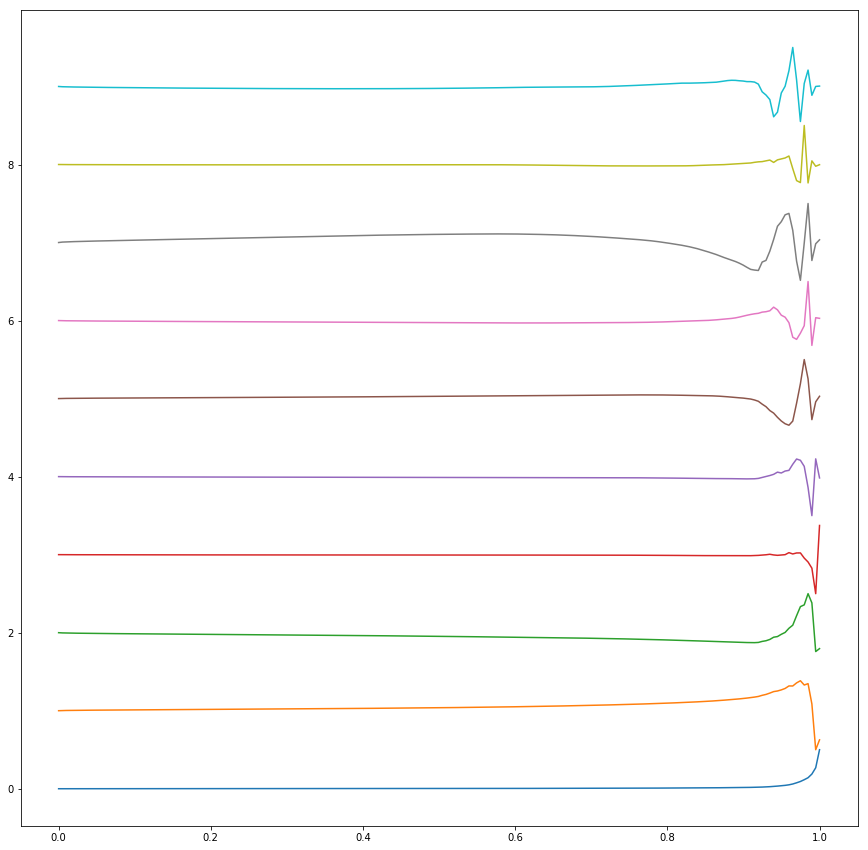

In [30]:
from sklearn.decomposition import PCA
X_pre = dists
pca = PCA(n_components=20)
pca.fit(X_pre)
X = pca.transform(X_pre)

plt.figure(figsize=[15,15])
for i in range(10):
    comp = pca.components_[i]
    plt.plot(np.linspace(0,1,200), comp/abs(comp).max()/2+i)

Using PCA, it seems that most of the variations occur in the upper percentiles
of the distribution (not surprising). I think that this reinforces the idea of
micro-slips causing creating noise since most of the variations would occur in
the tail of the distribution.

Let's try to use these features to build a predictor.
I decided to use a $k$-NN regressor as it tends to be less fussy. In the above
picture, it seems that the bottom three features are most informative. The rest
look like they are a product of too little data.

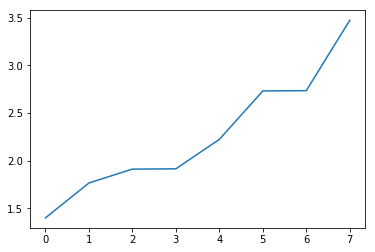

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=100, weights='distance')
X_post = X[:,:3]
plt.plot(np.sort(-cross_val_score(reg, X_post, ys, cv=8, n_jobs=4, scoring='neg_mean_absolute_error')));

In [40]:
reg.fit(X_post, ys)

@dask.delayed
def predict(fname):
    fdf = pd.read_csv(fname)
    x = fdf.acoustic_data.values
    x = resample(x)
    x = icdf(x)
    x = pca.transform(x[None,:])
    y = reg.predict(x[:,:3])
    return y[0]
    
import glob
files = pd.DataFrame(glob.glob('../input/test/*.csv'), columns=['filename'])
files['seg_id'] = files.filename.str.extract('.*/(seg_.*).csv', expand=True)
with ProgressBar():
    predictions = dask.compute(*(predict(fname) for fname in files.filename))
files['time_to_failure'] = predictions
files[['seg_id','time_to_failure']].to_csv('submission.csv', index=False)

[########################################] | 100% Completed |  1min 31.8s


In [41]:
!head submission.csv

seg_id,time_to_failure
seg_d5df41,6.674439709270235
seg_abda04,7.197214948678291
seg_421a96,5.397914623799299
seg_d31583,8.67974840869289
seg_14c054,8.753936517974807
seg_e2b8b1,9.448240435556867
seg_166f70,9.484276028846484
seg_a7b454,3.824006525979696
seg_a9a820,4.127052123638469
